### Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import openpyxl
import os 

# Algoritmos
# =============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt

#### Parameters

In [2]:
input_data = r'C:\wokspace_github\Data\output_data'

### Segmentacion de cliente

In [3]:
df = pd.read_parquet(os.path.join(input_data,"Score_perfil_cliente.parquet"))

**Clientes que cumplen el contraro**

In [4]:
df_cumplen = df[df['NON_COMPLIANT_CONTRACT'] == 0].copy()

In [5]:
df_cumplen.shape

(42029, 71)

### Arbol de decision

In [6]:
target = 'NAME_PRODUCT_TYPE'

# Excluimos variables no predictoras o que no queremos usar:
exclude_vars = ['NON_COMPLIANT_CONTRACT', 'NAME_PRODUCT_TYPE', 'LAST_UPDATE','CLIENT_ID','CURRENCY']
features = [col for col in df_cumplen.columns if col not in exclude_vars]

X = df_cumplen[features]
y = df_cumplen[target]

# Identificar variables categóricas y numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [7]:
# Codificar variables categóricas con OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])

# Dividir datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\renev\AppData\Local\Temp\ipykernel_25864\2428630337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = encoder.fit_transform(X[cat_cols])


In [8]:
# Entrenar árbol de decisión
tree = DecisionTreeClassifier(min_samples_split=50,max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# 7. Evaluar (opcional)
print("Precisión en test:", tree.score(X_test, y_test))

Precisión en test: 0.9848917439923864


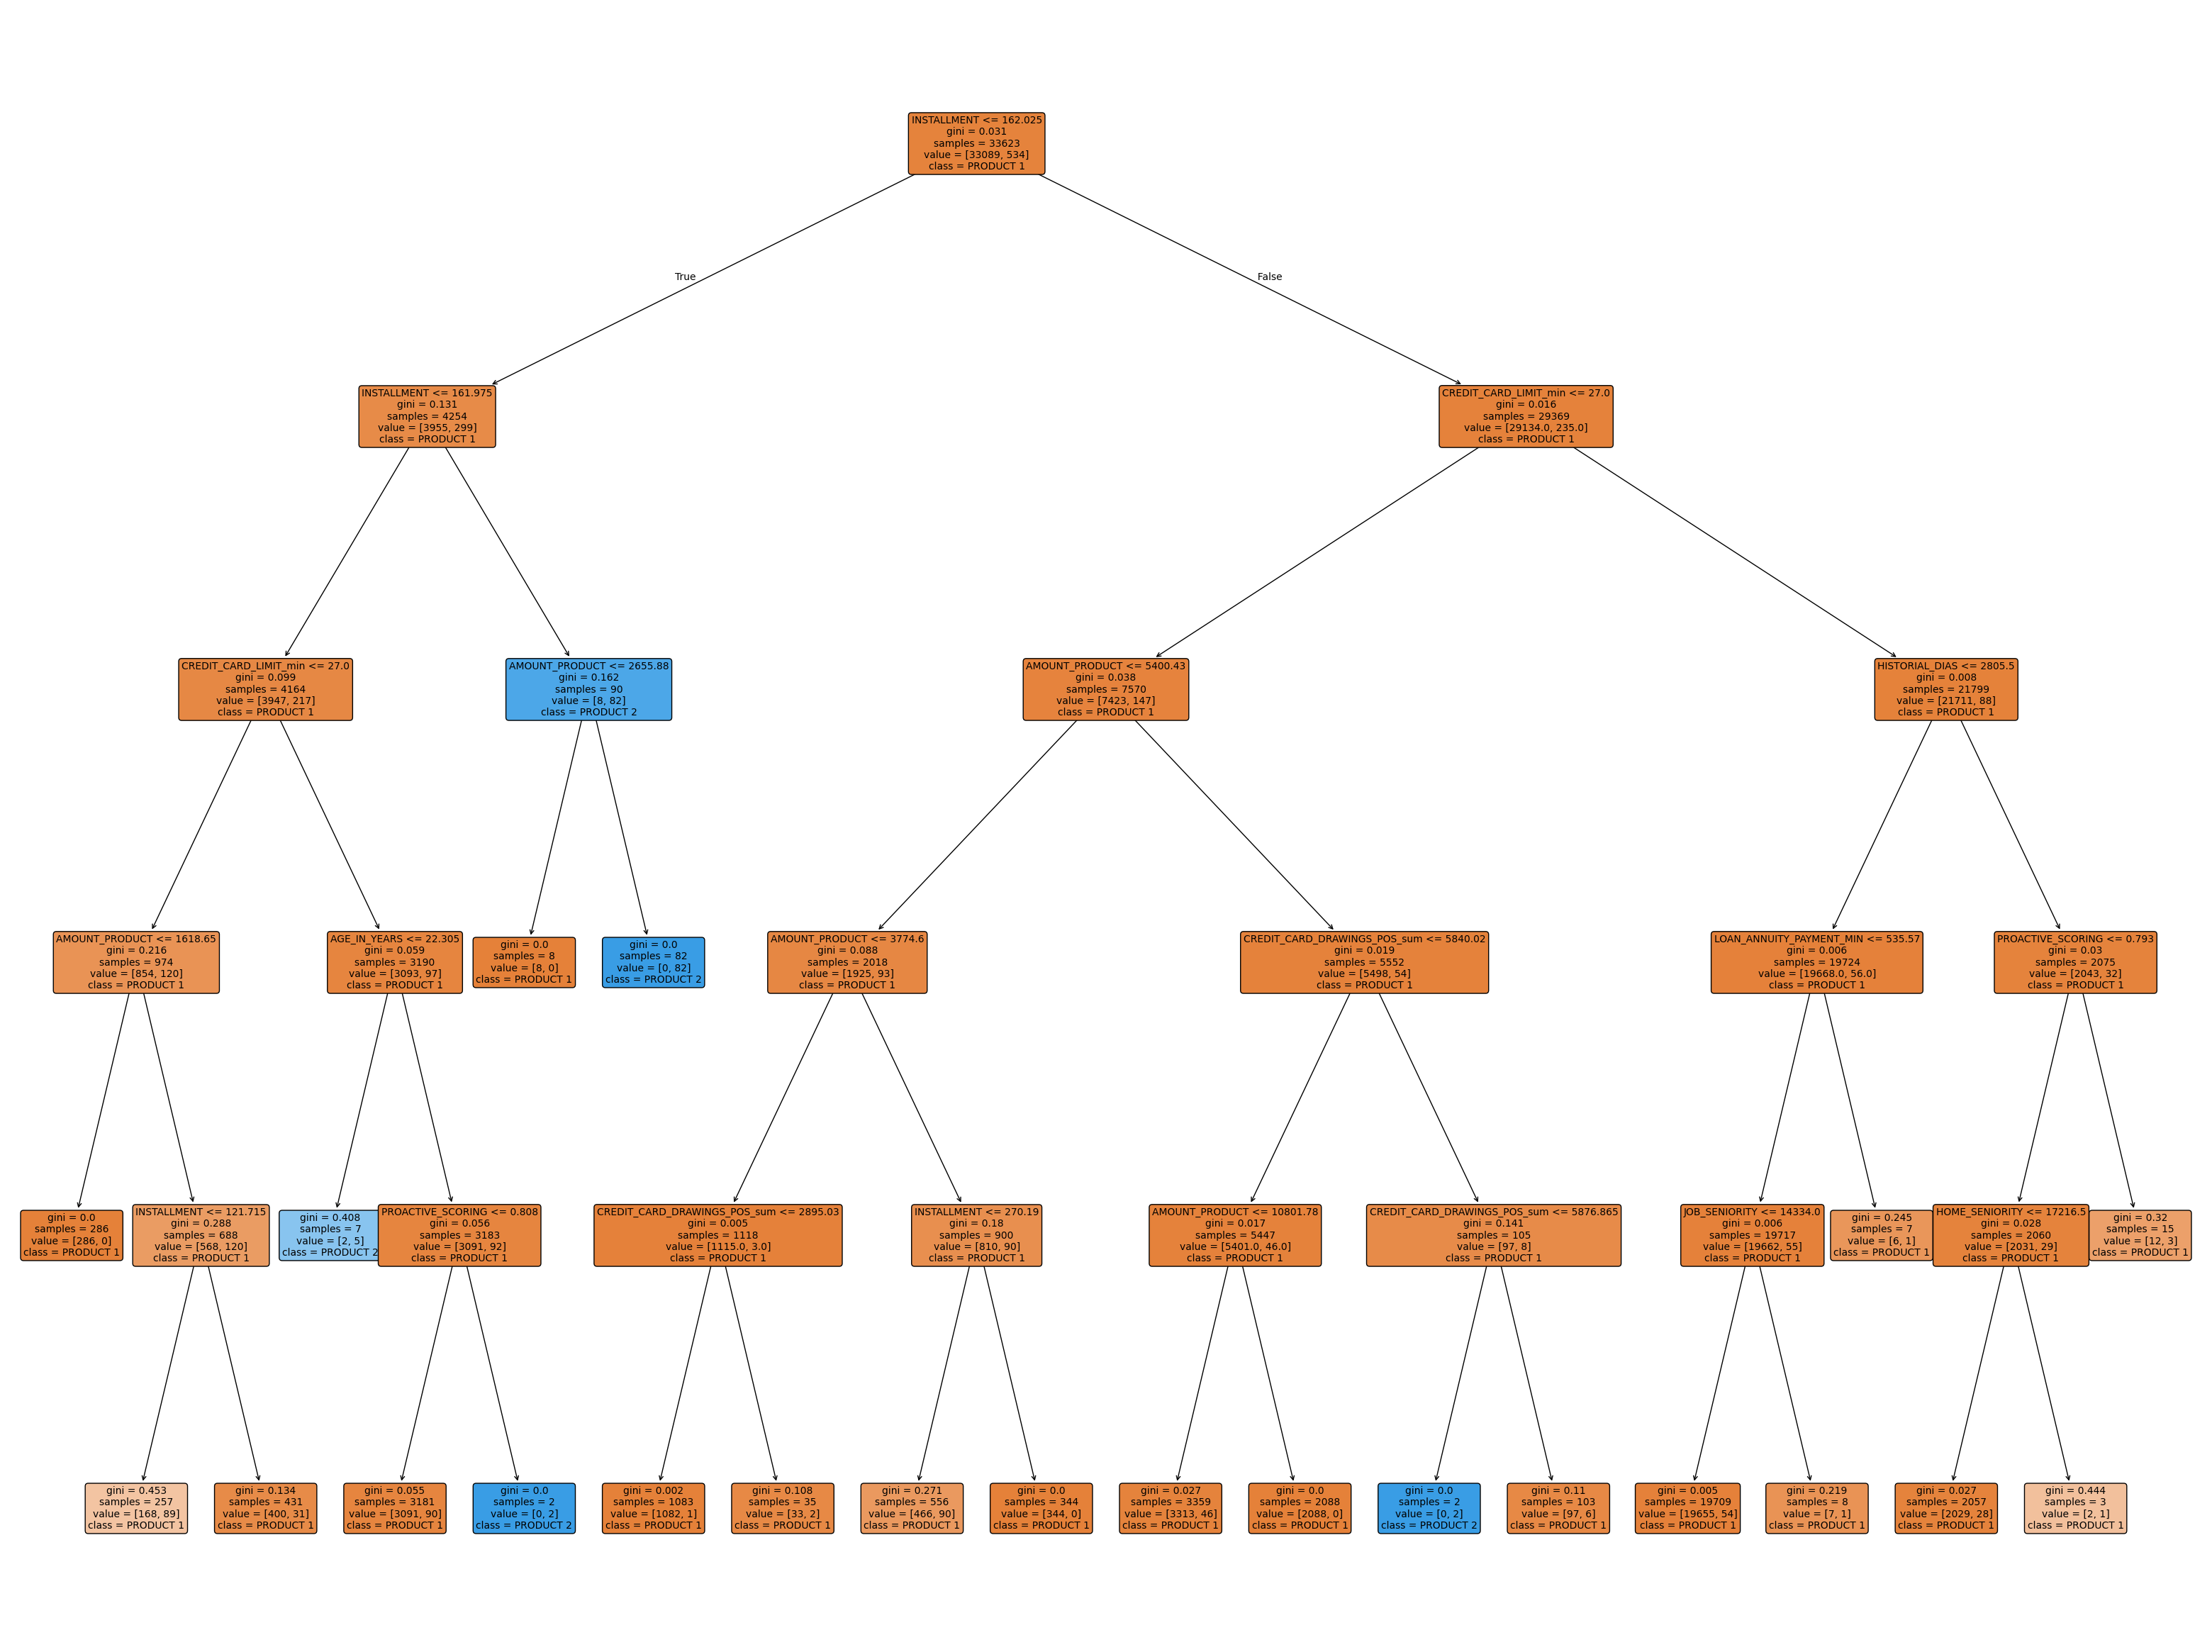

In [9]:
# 8. Visualizar árbol
plt.figure(figsize=(40,30))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True, rounded=True, fontsize=10)
plt.show()

In [10]:
predicciones = tree.predict(X)
probabilidad = tree.predict_proba(X)[:, 1]

In [11]:
df_cumplen['producto_recomendado_clasificacion'] = predicciones
df_cumplen['producto_recomendado_probabilidad'] = probabilidad

In [12]:
df_cumplen.to_parquet(os.path.join(input_data,"producto_recomendado.parquet"), index=False)
#df_cumplen.to_excel(os.path.join(input_data,"producto_recomendado.xlsx"), index=False)

In [13]:
rules_text = export_text(tree, feature_names=list(X.columns))
print(rules_text)

|--- INSTALLMENT <= 162.03
|   |--- INSTALLMENT <= 161.97
|   |   |--- CREDIT_CARD_LIMIT_min <= 27.00
|   |   |   |--- AMOUNT_PRODUCT <= 1618.65
|   |   |   |   |--- class: PRODUCT 1
|   |   |   |--- AMOUNT_PRODUCT >  1618.65
|   |   |   |   |--- INSTALLMENT <= 121.72
|   |   |   |   |   |--- class: PRODUCT 1
|   |   |   |   |--- INSTALLMENT >  121.72
|   |   |   |   |   |--- class: PRODUCT 1
|   |   |--- CREDIT_CARD_LIMIT_min >  27.00
|   |   |   |--- AGE_IN_YEARS <= 22.31
|   |   |   |   |--- class: PRODUCT 2
|   |   |   |--- AGE_IN_YEARS >  22.31
|   |   |   |   |--- PROACTIVE_SCORING <= 0.81
|   |   |   |   |   |--- class: PRODUCT 1
|   |   |   |   |--- PROACTIVE_SCORING >  0.81
|   |   |   |   |   |--- class: PRODUCT 2
|   |--- INSTALLMENT >  161.97
|   |   |--- AMOUNT_PRODUCT <= 2655.88
|   |   |   |--- class: PRODUCT 1
|   |   |--- AMOUNT_PRODUCT >  2655.88
|   |   |   |--- class: PRODUCT 2
|--- INSTALLMENT >  162.03
|   |--- CREDIT_CARD_LIMIT_min <= 27.00
|   |   |--- AMOUNT_PR